# Предсказание цен на недвижимость

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.image as img
matplotlib.rcParams.update({'font.size':14})
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

#### Описание датасета  

Id - идентификационный номер квартиры  
DistrictId - идентификационный номер района  
Rooms - количество комнат  
Square - площадь  
LifeSquare - жилая площадь  
KitchenSquare - площадь кухни  
Floor - этаж  
HouseFloor - количество этажей в доме  
HouseYear - год постройки дома  
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности  
Social_1, Social_2, Social_3 - социальные показатели местности  
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья  
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров  
Price - цена квартиры  


#### указание пути к файлам

In [3]:
TEST = 'test.csv'
TRAIN = 'train.csv'
TEST_PREP = 'preptest.csv'
TRAIN_PREP = 'preptrain.csv'

##### создание датафрейма для обработки

In [4]:
df = pd.read_csv(TRAIN)

In [5]:
df_test = pd.read_csv(TEST)

In [6]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [7]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [9]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Обзор переменных

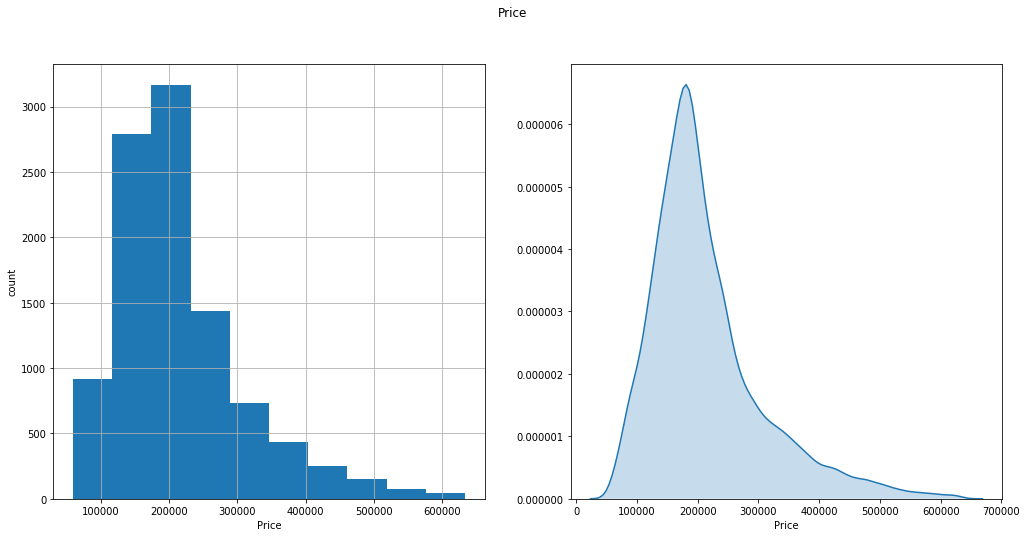

In [10]:
plt.figure(figsize= (17, 8))

plt.subplot(121)
df['Price'].hist()

plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)

sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Price')
plt.show()

In [11]:
df_num_features = df.select_dtypes(include=['int64'])

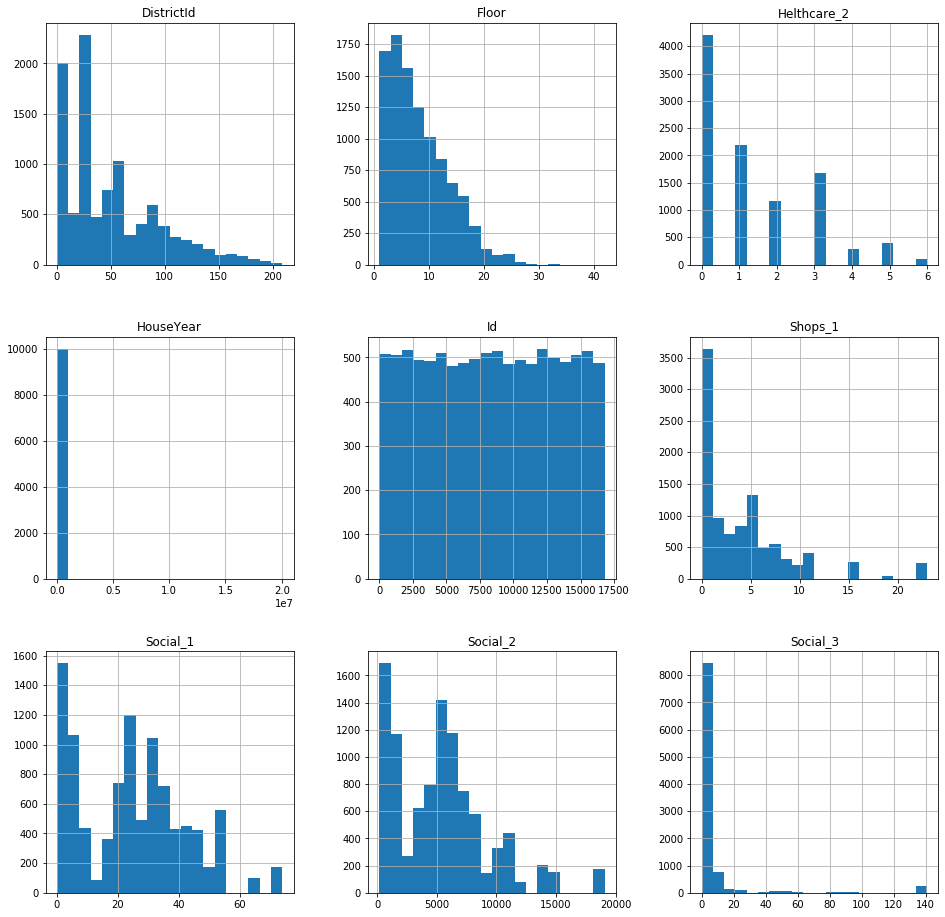

In [12]:
df_num_features.hist(figsize=(16,16), bins=20, grid=True);

In [13]:
df_num_features = df.select_dtypes(include=['float64'])

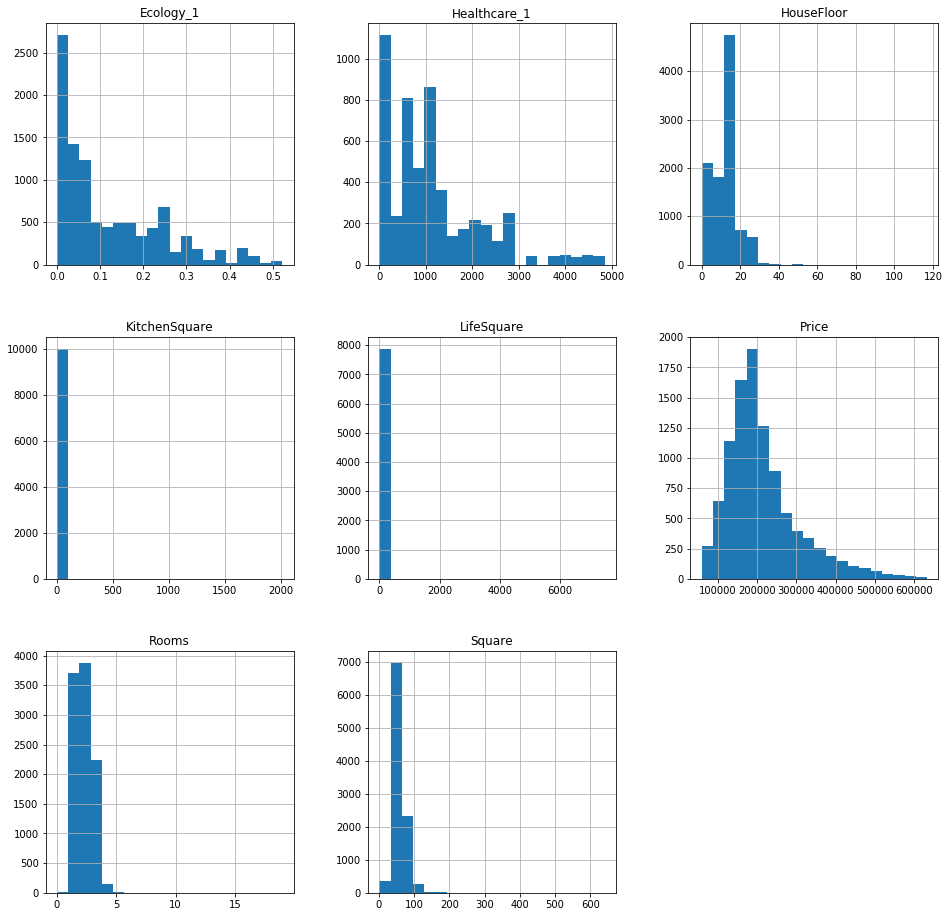

In [14]:
df_num_features.hist(figsize=(16,16), bins=20, grid=True);

### Обработка исходных данных

#### Исключаем признак ID

In [15]:
df = df[df.columns[1:]]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(8), object(3)
memory usage: 1.4+ MB


#### Поиск пустых значений

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(8), object(3)
memory usage: 1.4+ MB


#### удаление признака Healthcare_1 и рачет средней площади комнаты

In [18]:
df['Healthcare_1'].value_counts()

540.0     511
30.0      348
1046.0    245
750.0     163
229.0     148
         ... 
370.0      14
32.0       12
1815.0     10
35.0        2
0.0         1
Name: Healthcare_1, Length: 79, dtype: int64

In [19]:
##df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = 0  ## спорная замена

In [20]:
df.drop('Healthcare_1', axis=1, inplace=True)

In [21]:
df['Square'].median()//df['Rooms'].mode()[0]

26.0

In [22]:
df = df[df['Rooms'] > 0].reset_index(drop=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9992 entries, 0 to 9991
Data columns (total 18 columns):
DistrictId       9992 non-null int64
Rooms            9992 non-null float64
Square           9992 non-null float64
LifeSquare       7882 non-null float64
KitchenSquare    9992 non-null float64
Floor            9992 non-null int64
HouseFloor       9992 non-null float64
HouseYear        9992 non-null int64
Ecology_1        9992 non-null float64
Ecology_2        9992 non-null object
Ecology_3        9992 non-null object
Social_1         9992 non-null int64
Social_2         9992 non-null int64
Social_3         9992 non-null int64
Helthcare_2      9992 non-null int64
Shops_1          9992 non-null int64
Shops_2          9992 non-null object
Price            9992 non-null float64
dtypes: float64(7), int64(8), object(3)
memory usage: 1.4+ MB


In [24]:
df = df[df['LifeSquare'].notnull()].reset_index(drop=True)

In [25]:
df = df[df['Square'].notnull()].reset_index(drop=True)

In [26]:
df = df[df['Square'] > df['LifeSquare']].reset_index(drop=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7400 entries, 0 to 7399
Data columns (total 18 columns):
DistrictId       7400 non-null int64
Rooms            7400 non-null float64
Square           7400 non-null float64
LifeSquare       7400 non-null float64
KitchenSquare    7400 non-null float64
Floor            7400 non-null int64
HouseFloor       7400 non-null float64
HouseYear        7400 non-null int64
Ecology_1        7400 non-null float64
Ecology_2        7400 non-null object
Ecology_3        7400 non-null object
Social_1         7400 non-null int64
Social_2         7400 non-null int64
Social_3         7400 non-null int64
Helthcare_2      7400 non-null int64
Shops_1          7400 non-null int64
Shops_2          7400 non-null object
Price            7400 non-null float64
dtypes: float64(7), int64(8), object(3)
memory usage: 1.0+ MB


In [28]:
df = df[df['Rooms'] < 5].reset_index(drop=True)

In [29]:
df['Rooms'].value_counts()

2.0    2890
1.0    2609
3.0    1747
4.0     134
Name: Rooms, dtype: int64

In [30]:
df = df[df['KitchenSquare'] < 30].reset_index(drop=True)

In [31]:
##df.loc[df['KitchenSquare']+df['LifeSquare']> df['Square'],'Square' ] = df['KitchenSquare']+df['LifeSquare']

In [32]:
df = df[df['KitchenSquare']+df['LifeSquare']< df['Square']].reset_index(drop=True)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7012 entries, 0 to 7011
Data columns (total 18 columns):
DistrictId       7012 non-null int64
Rooms            7012 non-null float64
Square           7012 non-null float64
LifeSquare       7012 non-null float64
KitchenSquare    7012 non-null float64
Floor            7012 non-null int64
HouseFloor       7012 non-null float64
HouseYear        7012 non-null int64
Ecology_1        7012 non-null float64
Ecology_2        7012 non-null object
Ecology_3        7012 non-null object
Social_1         7012 non-null int64
Social_2         7012 non-null int64
Social_3         7012 non-null int64
Helthcare_2      7012 non-null int64
Shops_1          7012 non-null int64
Shops_2          7012 non-null object
Price            7012 non-null float64
dtypes: float64(7), int64(8), object(3)
memory usage: 986.2+ KB


In [34]:
df['Helthcare_2'].value_counts()

0    2082
1    1925
3    1336
2     959
5     358
4     271
6      81
Name: Helthcare_2, dtype: int64

In [35]:
#df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square']- df['KitchenSquare']

In [36]:
df.loc[df['Square'] < df['LifeSquare'],'Square'] = df['KitchenSquare'] + df['LifeSquare']

In [37]:
df.loc[df['HouseYear'] > 2019, 'HouseYear'] = 2019

In [38]:
df.loc[df['Floor'] > df['HouseFloor'],'HouseFloor'] = df['Floor']

In [39]:
df.loc[df['HouseFloor'] > 90, 'HouseFloor'] = 

In [40]:
df['HouseFloor'].median()

12.0

In [41]:
##df.loc[df['Healthcare_1'].isnull(),'Healthcare_1'] = df['Healthcare_1'].mode()[0] 

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7012 entries, 0 to 7011
Data columns (total 18 columns):
DistrictId       7012 non-null int64
Rooms            7012 non-null float64
Square           7012 non-null float64
LifeSquare       7012 non-null float64
KitchenSquare    7012 non-null float64
Floor            7012 non-null int64
HouseFloor       7012 non-null float64
HouseYear        7012 non-null int64
Ecology_1        7012 non-null float64
Ecology_2        7012 non-null object
Ecology_3        7012 non-null object
Social_1         7012 non-null int64
Social_2         7012 non-null int64
Social_3         7012 non-null int64
Helthcare_2      7012 non-null int64
Shops_1          7012 non-null int64
Shops_2          7012 non-null object
Price            7012 non-null float64
dtypes: float64(7), int64(8), object(3)
memory usage: 986.2+ KB


In [43]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,7012.000000,7012.000000,7012.000000,7012.000000,7012.000000,7012.000000,7012.000000,7012.000000,7012.000000,7012.000000,7012.000000,7012.000000,7012.000000,7012.000000,7012.000000
mean,59.196378,1.927838,54.496426,33.210052,7.122932,7.958642,12.630205,1983.934113,0.124702,29.939247,6376.714489,7.115231,1.598831,4.648745,225542.603756
std,46.178800,0.808023,17.530927,14.396954,3.112818,4.920535,5.603121,18.781850,0.121225,15.965187,3797.423030,18.326197,1.513620,4.302130,93393.636575
min,0.000000,1.000000,4.633498,0.370619,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028
25%,22.000000,1.000000,41.090039,22.337599,5.000000,4.000000,9.000000,1970.000000,0.033494,21.000000,4231.000000,1.000000,0.000000,1.000000,165473.458453
50%,48.000000,2.000000,50.172904,31.432063,7.000000,7.000000,12.000000,1978.000000,0.090799,30.000000,5735.000000,3.000000,1.000000,4.000000,201805.475706
75%,91.000000,3.000000,64.081385,42.258426,9.000000,11.000000,17.000000,2001.000000,0.194489,39.000000,7960.000000,6.000000,3.000000,6.000000,264704.678421
max,209.000000,4.000000,190.857689,161.155275,29.000000,42.000000,48.000000,2019.000000,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,625678.644994


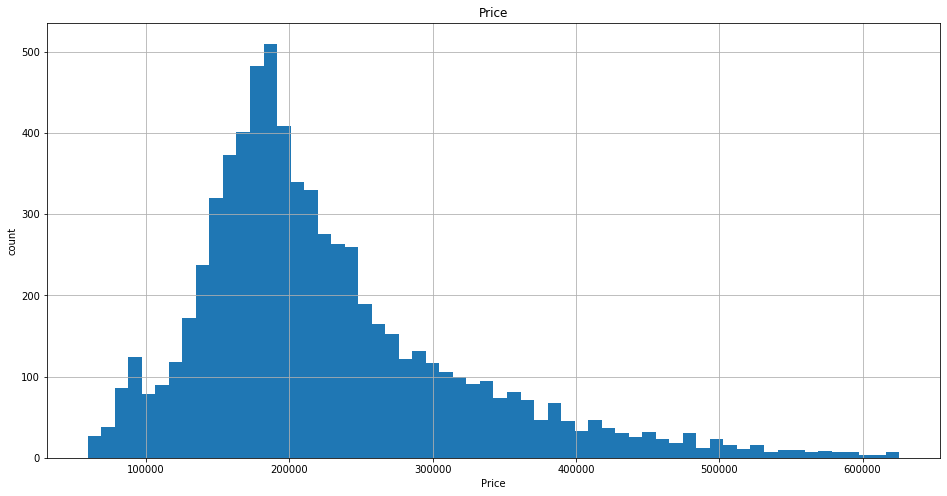

In [44]:
plt.figure(figsize = (16, 8))

df['Price'].hist(bins=60)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Price')
plt.show()

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7012 entries, 0 to 7011
Data columns (total 18 columns):
DistrictId       7012 non-null int64
Rooms            7012 non-null float64
Square           7012 non-null float64
LifeSquare       7012 non-null float64
KitchenSquare    7012 non-null float64
Floor            7012 non-null int64
HouseFloor       7012 non-null float64
HouseYear        7012 non-null int64
Ecology_1        7012 non-null float64
Ecology_2        7012 non-null object
Ecology_3        7012 non-null object
Social_1         7012 non-null int64
Social_2         7012 non-null int64
Social_3         7012 non-null int64
Helthcare_2      7012 non-null int64
Shops_1          7012 non-null int64
Shops_2          7012 non-null object
Price            7012 non-null float64
dtypes: float64(7), int64(8), object(3)
memory usage: 986.2+ KB


In [46]:
df['Helthcare_2'] = df['Helthcare_2'].astype(object)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7012 entries, 0 to 7011
Data columns (total 18 columns):
DistrictId       7012 non-null int64
Rooms            7012 non-null float64
Square           7012 non-null float64
LifeSquare       7012 non-null float64
KitchenSquare    7012 non-null float64
Floor            7012 non-null int64
HouseFloor       7012 non-null float64
HouseYear        7012 non-null int64
Ecology_1        7012 non-null float64
Ecology_2        7012 non-null object
Ecology_3        7012 non-null object
Social_1         7012 non-null int64
Social_2         7012 non-null int64
Social_3         7012 non-null int64
Helthcare_2      7012 non-null object
Shops_1          7012 non-null int64
Shops_2          7012 non-null object
Price            7012 non-null float64
dtypes: float64(7), int64(7), object(4)
memory usage: 986.2+ KB


In [48]:
df['Ecology_2'].value_counts()

B    6921
A      91
Name: Ecology_2, dtype: int64

##### Приведение к бинарным признакам

In [49]:
df = pd.concat([df, pd.get_dummies(df[['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2']])], axis=1)

In [50]:
df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Ecology_3_B,Shops_2_A,Shops_2_B,Helthcare_2_0,Helthcare_2_1,Helthcare_2_2,Helthcare_2_3,Helthcare_2_4,Helthcare_2_5,Helthcare_2_6
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,...,1,0,1,1,0,0,0,0,0,0
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,...,1,0,1,0,1,0,0,0,0,0
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,...,1,0,1,0,1,0,0,0,0,0
3,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,...,1,0,1,0,0,1,0,0,0,0
4,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,...,1,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7007,13,3.0,80.631333,48.899083,10.0,11,14.0,1999,0.090799,B,...,1,0,1,0,0,0,0,0,1,0
7008,32,2.0,50.401785,30.476203,5.0,6,6.0,1968,0.135650,B,...,1,0,1,0,0,0,1,0,0,0
7009,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,...,1,1,0,1,0,0,0,0,0,0
7010,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,...,0,0,1,0,0,1,0,0,0,0


#### Отбор признаков

In [51]:
df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'Helthcare_2_0',
 'Helthcare_2_1',
 'Helthcare_2_2',
 'Helthcare_2_3',
 'Helthcare_2_4',
 'Helthcare_2_5',
 'Helthcare_2_6']

In [52]:
feature_names = ['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',

 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',

 
 'Ecology_2_A',
 
 'Ecology_3_A',
 
 'Shops_2_A',
 
 'Helthcare_2_0',
 'Helthcare_2_1',
 'Helthcare_2_2',
 'Helthcare_2_3',
 'Helthcare_2_4',
 'Helthcare_2_5'
 ]

In [53]:
target_name = 'Price'

In [54]:
df = df[feature_names + [target_name]]
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Ecology_2_A,Ecology_3_A,Shops_2_A,Helthcare_2_0,Helthcare_2_1,Helthcare_2_2,Helthcare_2_3,Helthcare_2_4,Helthcare_2_5,Price
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,...,0,0,0,1,0,0,0,0,0,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,...,0,0,0,0,1,0,0,0,0,300009.450063
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,...,0,0,0,0,1,0,0,0,0,220925.908524
3,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,...,0,0,0,0,0,1,0,0,0,150226.531644
4,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,35,...,0,0,0,1,0,0,0,0,0,215898.447742


#### Стандартизация признаков

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7012 entries, 0 to 7011
Data columns (total 24 columns):
DistrictId       7012 non-null int64
Rooms            7012 non-null float64
Square           7012 non-null float64
LifeSquare       7012 non-null float64
KitchenSquare    7012 non-null float64
Floor            7012 non-null int64
HouseFloor       7012 non-null float64
HouseYear        7012 non-null int64
Ecology_1        7012 non-null float64
Social_1         7012 non-null int64
Social_2         7012 non-null int64
Social_3         7012 non-null int64
Helthcare_2      7012 non-null object
Shops_1          7012 non-null int64
Ecology_2_A      7012 non-null uint8
Ecology_3_A      7012 non-null uint8
Shops_2_A        7012 non-null uint8
Helthcare_2_0    7012 non-null uint8
Helthcare_2_1    7012 non-null uint8
Helthcare_2_2    7012 non-null uint8
Helthcare_2_3    7012 non-null uint8
Helthcare_2_4    7012 non-null uint8
Helthcare_2_5    7012 non-null uint8
Price            7012 non-nul

In [56]:
feature_names_for_stand = df[feature_names].select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_names_for_stand

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Shops_1']

In [57]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [58]:
stand_features

array([[-0.52400892,  0.08931328, -0.37164772, ...,  0.42118024,
        -0.1154294 ,  1.47640998],
       [-0.3940699 ,  1.32699062,  0.63818713, ...,  1.03558806,
        -0.33371174,  2.63870782],
       [-0.13419187,  0.08931328, -0.5447033 , ...,  0.36403215,
        -0.38828232, -0.38326655],
       ...,
       [-0.89216946, -1.14836406, -0.74016651, ..., -0.21455934,
        -0.38828232,  0.08165258],
       [ 0.34225119,  0.08931328, -0.62145265, ..., -0.34992394,
         0.10285295,  0.08165258],
       [ 1.49004583, -1.14836406, -0.90302752, ..., -0.41576276,
        -0.38828232,  0.77903128]])

In [59]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [60]:
df.head(20)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Ecology_2_A,Ecology_3_A,Shops_2_A,Helthcare_2_0,Helthcare_2_1,Helthcare_2_2,Helthcare_2_3,Helthcare_2_4,Helthcare_2_5,Price
0,-0.524009,0.089313,-0.371648,-0.261692,-0.360770,-0.194839,-0.647936,-0.795192,-0.294207,0.191728,...,0,0,0,1,0,0,0,0,0,184966.930730
1,-0.394070,1.326991,0.638187,0.475099,0.281780,-0.194839,-0.647936,-0.315972,-1.028183,1.006058,...,0,0,0,0,1,0,0,0,0,300009.450063
2,-0.134192,0.089313,-0.544703,-0.278721,-2.288422,0.008406,-0.112482,-0.848439,-0.619267,0.254369,...,0,0,0,0,1,0,0,0,0,220925.908524
3,0.862007,-1.148364,-0.846977,-0.655316,-0.039495,0.618139,-0.112482,-0.422465,-0.926968,0.317009,...,0,0,0,0,0,1,0,0,0,150226.531644
4,-0.004253,1.326991,1.476813,0.935936,1.566881,-0.601328,0.779941,1.441169,1.524357,0.317009,...,0,0,0,1,0,0,0,0,0,215898.447742
5,2.053115,0.089313,0.442546,0.274406,-0.039495,-1.007816,-1.361875,-1.274412,2.770704,-0.622602,...,0,0,0,0,1,0,0,0,0,296021.204377
6,-0.783887,-1.148364,-0.458367,-0.992954,0.281780,1.024628,0.779941,1.600909,-0.403607,-1.499572,...,0,0,0,1,0,0,0,0,0,95380.220993
7,-0.675604,0.089313,-0.467294,-0.367289,-0.360770,0.008406,-0.647936,-0.582205,-0.050860,0.003806,...,0,0,0,0,1,0,0,0,0,204243.553129
8,-0.610635,1.326991,0.816469,0.870166,-0.039495,-1.414305,-0.826421,-1.327659,-1.028761,-0.434680,...,0,0,0,1,0,0,0,0,0,165534.541425
9,-1.000452,0.089313,0.001505,-0.100744,-1.967146,0.008406,-0.112482,0.802209,-0.279693,2.759999,...,0,0,0,0,0,0,0,0,1,229220.372609


#### Матрица корреляций

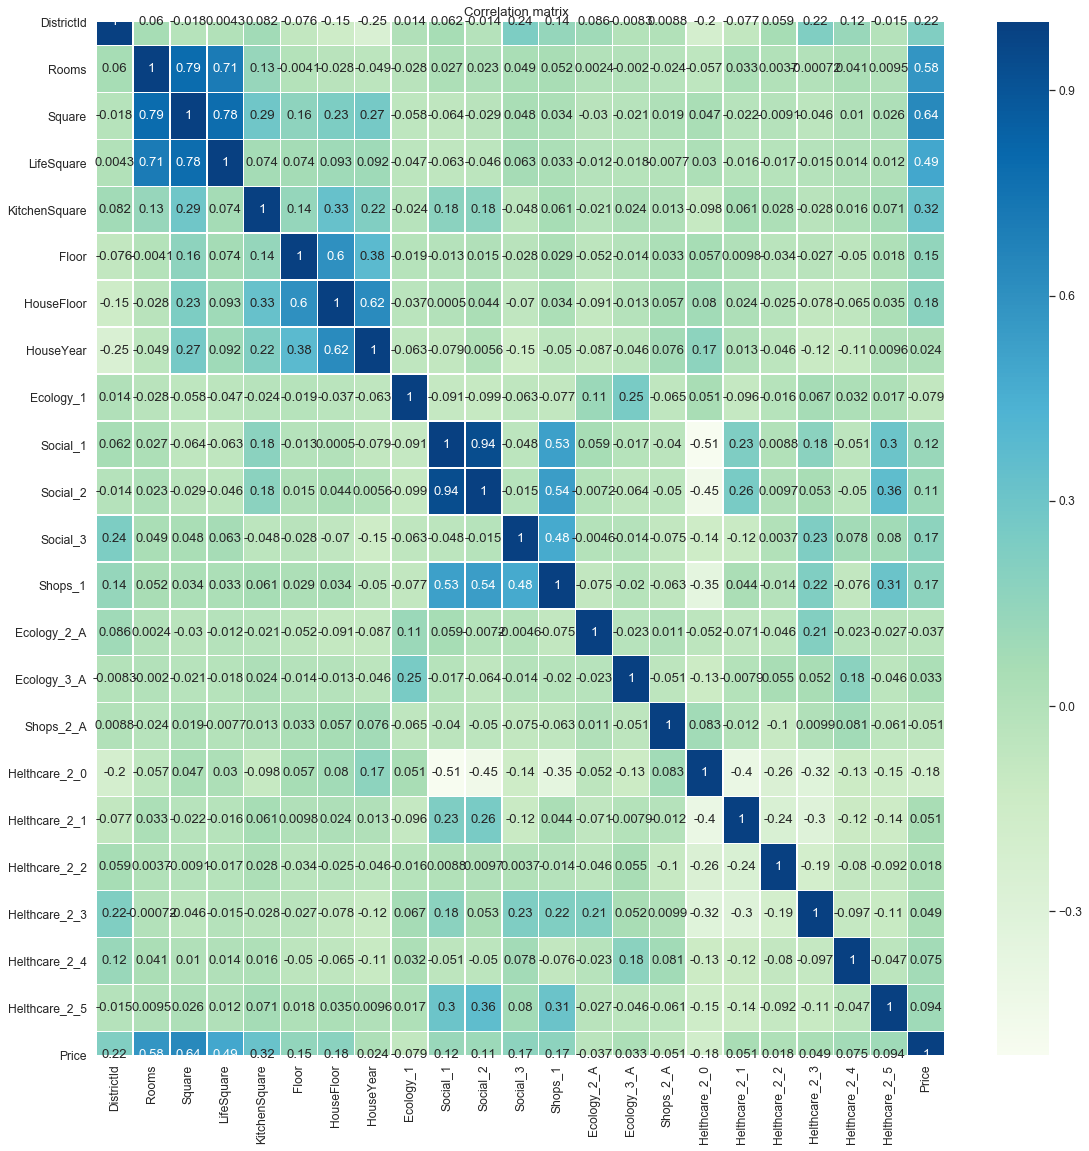

In [61]:
plt.figure(figsize = (19,19))

sns.set(font_scale=1.1)
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix  ')
plt.show()

#### Сохранение обработанного обучающего датасета в csv

In [62]:
df.to_csv(TEST_PREP, index=False, encoding='utf-8')

#### Разбиение на train и test

In [63]:
x = df[feature_names]
y = df[target_name]

In [64]:
x

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Shops_1,Ecology_2_A,Ecology_3_A,Shops_2_A,Helthcare_2_0,Helthcare_2_1,Helthcare_2_2,Helthcare_2_3,Helthcare_2_4,Helthcare_2_5
0,-0.524009,0.089313,-0.371648,-0.261692,-0.360770,-0.194839,-0.647936,-0.795192,-0.294207,0.191728,...,1.476410,0,0,0,1,0,0,0,0,0
1,-0.394070,1.326991,0.638187,0.475099,0.281780,-0.194839,-0.647936,-0.315972,-1.028183,1.006058,...,2.638708,0,0,0,0,1,0,0,0,0
2,-0.134192,0.089313,-0.544703,-0.278721,-2.288422,0.008406,-0.112482,-0.848439,-0.619267,0.254369,...,-0.383267,0,0,0,0,1,0,0,0,0
3,0.862007,-1.148364,-0.846977,-0.655316,-0.039495,0.618139,-0.112482,-0.422465,-0.926968,0.317009,...,-0.150807,0,0,0,0,0,1,0,0,0
4,-0.004253,1.326991,1.476813,0.935936,1.566881,-0.601328,0.779941,1.441169,1.524357,0.317009,...,0.314112,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7007,-1.000452,1.326991,1.490895,1.089824,0.924331,0.618139,0.244487,0.802209,-0.279693,2.759999,...,2.406248,0,0,0,0,0,0,0,0,1
7008,-0.588978,0.089313,-0.233583,-0.189904,-0.682046,-0.398083,-1.183390,-0.848439,0.090313,1.006058,...,1.476410,0,0,0,0,0,0,1,0,0
7009,-0.892169,-1.148364,-0.740167,-0.880168,0.603055,1.024628,0.066003,0.855455,-1.028761,0.003806,...,0.081653,0,0,1,1,0,0,0,0,0
7010,0.342251,0.089313,-0.621453,0.043769,0.281780,-1.414305,-1.361875,-1.221166,1.507755,0.003806,...,0.081653,0,1,0,0,0,1,0,0,0


In [65]:
from sklearn.model_selection import train_test_split

In [66]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=42)

## Построение базовых моделей и выбор лучшей

#### Линейная регрессия

In [67]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

R2:	0.557
MAE:	42150.121
MSE:	3831326694.205


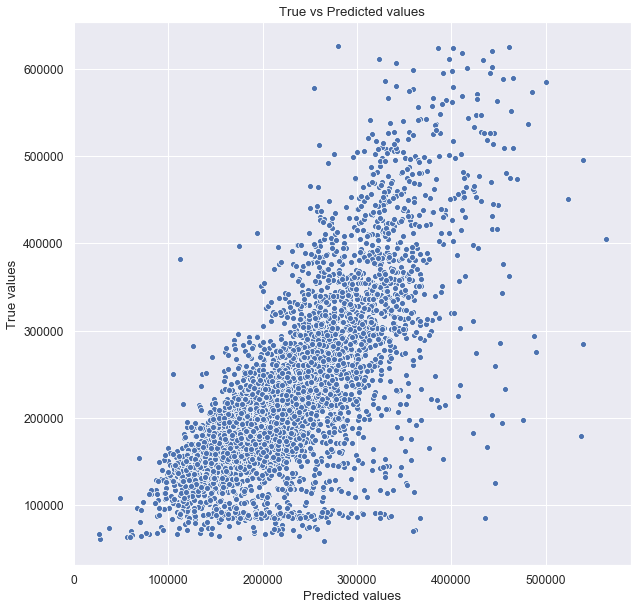

In [68]:
y_train_preds = lr_model.predict(x_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.517
MAE:	43903.996
MSE:	4317072401.299


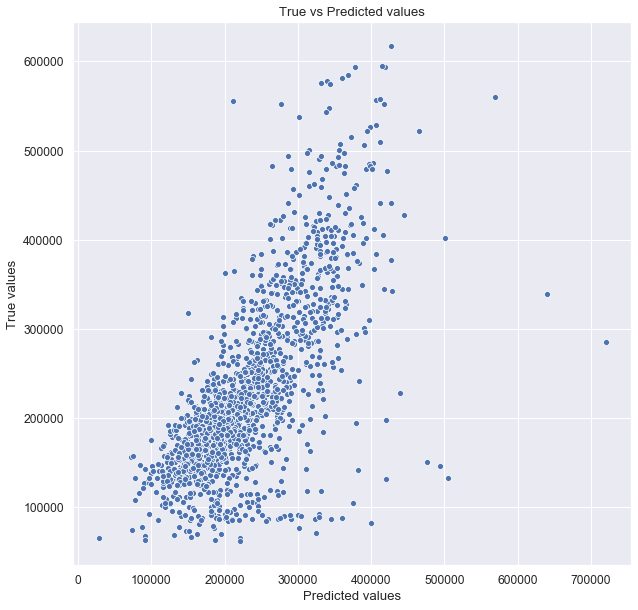

In [69]:
y_test_preds = lr_model.predict(x_test)
evaluate_preds(y_test, y_test_preds)

Text(0, 0.5, 'Признак')

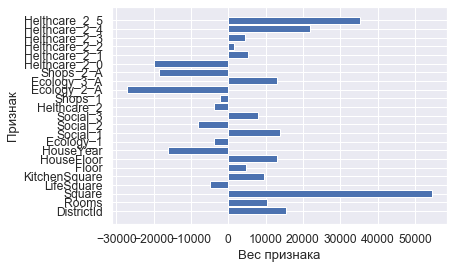

In [70]:
plt.barh(x_train.columns, lr_model.coef_.flatten())
plt.xlabel('Вес признака')
plt.ylabel('Признак')

#### Случайный лес

In [71]:
rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

R2:	0.941
MAE:	13541.036
MSE:	506852906.752


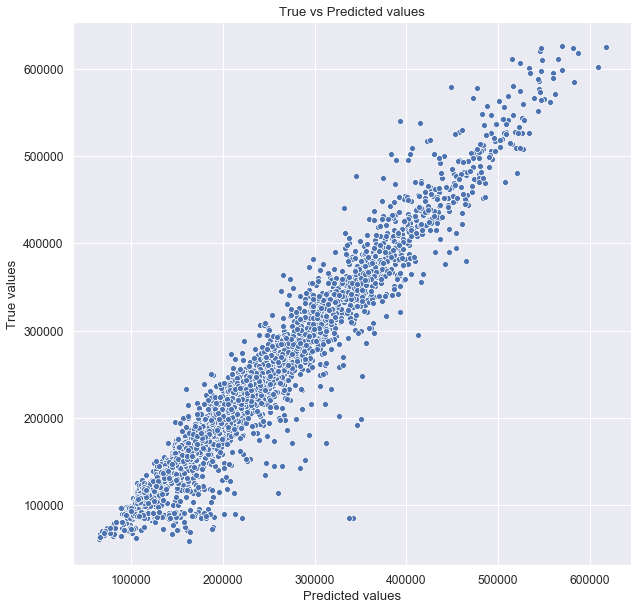

In [72]:
y_train_preds = rf_model.predict(x_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.626
MAE:	35273.473
MSE:	3347668484.494


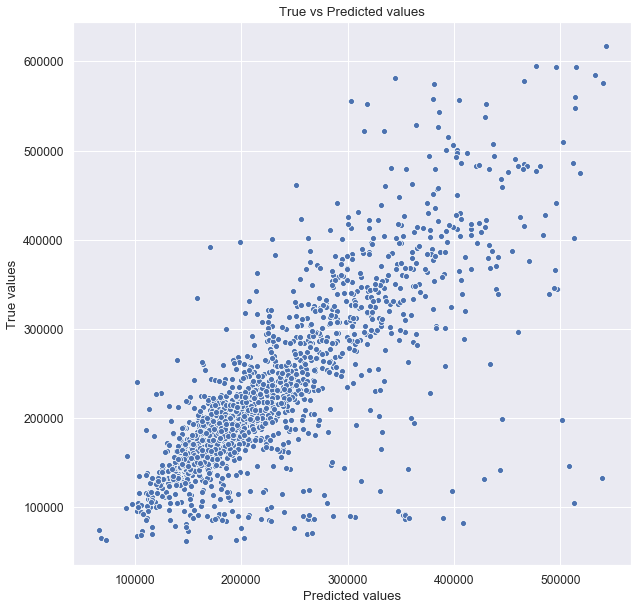

In [73]:
y_test_preds = rf_model.predict(x_test)
evaluate_preds(y_test, y_test_preds)